<a href="https://colab.research.google.com/github/Prajwalng2/DL-Project/blob/main/DL_project_brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F165566%2F377107%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240604%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240604T055317Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D103bc44be918940010b16d7b92439917cb8045cf5bd55ed0bb675714b91beb6a4739165413e9637264408dbfbc5f87a2ce82820fa11211afd5947549dd890a556999e7b063a1cea9c9be970e3f0bf9e0e887ec58f76220f934258bb95893432446335e81f025fe2b55f180baab32f565b430af74625b217da34544f22c1f23420b0546bcbdebf196e6bc34aeae6eba22f2e204a846956ce5a413d9b276ab23e037977f89fdef595bb499272b756fb2e81d8efc5ca5ae3e6e8816133a3d5699139f30e8dd7de1f71e3852dd264aafd596f5defbf611ff4cacc5ae29eda816993632b2f6b0f60d65439994d069135131c921831dd94ecd49611d08f1ec0da7ba4d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 15828590 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


In [4]:
!pip install umap-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.8 MB/s eta 0:00:00


In [6]:
from keras.utils import to_categorical


In [8]:
import numpy as np
import pandas as pd
import math
import cv2
import matplotlib.pyplot as plt
import os
import seaborn as sns
import umap
from PIL import Image
from scipy import misc
from os import listdir
from os.path import isfile, join
from scipy import misc
from random import shuffle
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils import to_categorical


In [9]:
os.listdir('../input/brain_tumor_dataset')

['yes', 'no']

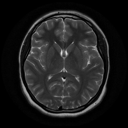

In [10]:
im =Image.open('../input/brain_tumor_dataset/no/1 no.jpeg').resize((128,128))
im

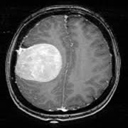

In [11]:
im =Image.open('../input/brain_tumor_dataset/yes/Y1.jpg').resize((128,128))
im

In [12]:
yes=os.listdir('../input/brain_tumor_dataset/yes')
no=os.listdir('../input/brain_tumor_dataset/no')

In [13]:
data=np.concatenate([yes,no])
len(data)==len(yes)+len(no)

True

In [14]:
target_x=np.full(len(yes),1)
target_y=np.full(len(no),0)
data_target=np.concatenate([target_x,target_y])
len(data_target)==len(target_x)+len(target_y)

True

In [15]:
len(data_target)==len(data)

True

In [16]:
data_target

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [17]:
data

array(['Y253.JPG', 'Y259.JPG', 'Y22.jpg', 'Y185.jpg', 'Y157.JPG',
       'Y181.jpg', 'Y1.jpg', 'Y105.jpg', 'Y243.JPG', 'Y38.jpg', 'Y28.jpg',
       'Y70.jpg', 'Y166.JPG', 'Y47.JPG', 'Y77.jpg', 'Y10.jpg', 'Y163.JPG',
       'Y95.jpg', 'Y36.JPG', 'Y153.jpg', 'Y86.JPG', 'Y65.JPG', 'Y34.jpg',
       'Y62.jpg', 'Y246.JPG', 'Y75.JPG', 'Y193.JPG', 'Y162.jpg',
       'Y42.jpg', 'Y114.JPG', 'Y183.jpg', 'Y52.jpg', 'Y60.jpg', 'Y61.jpg',
       'Y99.JPG', 'Y113.JPG', 'Y12.jpg', 'Y82.jpg', 'Y159.JPG',
       'Y252.jpg', 'Y112.JPG', 'Y98.JPG', 'Y4.jpg', 'Y45.JPG', 'Y251.JPG',
       'Y101.jpg', 'Y154.jpg', 'Y244.JPG', 'Y155.JPG', 'Y73.jpg',
       'Y79.jpg', 'Y182.JPG', 'Y107.jpg', 'Y258.JPG', 'Y164.JPG',
       'Y39.jpg', 'Y156.JPG', 'Y30.jpg', 'Y9.jpg', 'Y90.jpg', 'Y46.jpg',
       'Y116.JPG', 'Y20.jpg', 'Y245.jpg', 'Y146.JPG', 'Y184.JPG',
       'Y3.jpg', 'Y55.jpg', 'Y106.jpg', 'Y89.JPG', 'Y104.jpg', 'Y170.JPG',
       'Y54.jpg', 'Y180.jpg', 'Y108.jpg', 'Y59.JPG', 'Y256.JPG',
       'Y51.jpg', 'Y

In [18]:
yes_values=os.listdir('../input/brain_tumor_dataset/yes')
no_values=os.listdir('../input/brain_tumor_dataset/no')

In [19]:
X_data =[]
for file in yes_values:

    img = cv2.imread('../input/brain_tumor_dataset/yes/'+file)
    face = cv2.resize(img, (32, 32) )
    (b, g, r)=cv2.split(face)
    img=cv2.merge([r,g,b])
    X_data.append(img)

In [20]:

for file in no_values:

    img = cv2.imread('../input/brain_tumor_dataset/no/'+file)
    face = cv2.resize(img, (32, 32) )
    (b, g, r)=cv2.split(face)
    img=cv2.merge([r,g,b])
    X_data.append(img)

In [21]:
len(X_data)==len(data)==len(data_target)

True

In [22]:
X = np.squeeze(X_data)

In [23]:
X.shape

(253, 32, 32, 3)

In [24]:
X = X.astype('float32')
X /= 255

In [25]:
data_target

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [26]:
(x_train, y_train), (x_test, y_test) = (X[:190],data_target[:190]) , (X[190:] , data_target[190:])
(x_valid , y_valid) = (x_test[:63], y_test[:63])

In [27]:
model = tf.keras.Sequential()


model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=9, padding='same', activation='relu', input_shape=(32,32,3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.45))

model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=9,padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters=36, kernel_size=9, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.15))


model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        3904      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        20752     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 16)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 16)          0

In [28]:
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['acc'])

In [29]:
model.fit(x_train,
         y_train,
         batch_size=128,
         epochs=150,
         validation_data=(x_valid, y_valid),)

Epoch 1/150
2/2 [==============================] - 3s 906ms/step - loss: 0.5771 - acc: 0.6053 - val_loss: 2.5173 - val_acc: 0.0000e+00
Epoch 2/150
2/2 [==============================] - 1s 308ms/step - loss: 0.7410 - acc: 0.8158 - val_loss: 1.0106 - val_acc: 0.0000e+00
Epoch 3/150
2/2 [==============================] - 1s 598ms/step - loss: 0.4816 - acc: 0.8158 - val_loss: 0.8237 - val_acc: 0.0000e+00
Epoch 4/150
2/2 [==============================] - 1s 570ms/step - loss: 0.5320 - acc: 0.8158 - val_loss: 0.8485 - val_acc: 0.0000e+00
Epoch 5/150
2/2 [==============================] - 1s 546ms/step - loss: 0.5090 - acc: 0.8158 - val_loss: 0.9971 - val_acc: 0.0000e+00
Epoch 6/150
2/2 [==============================] - 1s 295ms/step - loss: 0.4650 - acc: 0.8158 - val_loss: 1.3457 - val_acc: 0.0000e+00
Epoch 7/150
2/2 [==============================] - 1s 382ms/step - loss: 0.4694 - acc: 0.8158 - val_loss: 1.5402 - val_acc: 0.0000e+00
Epoch 8/150
2/2 [==============================] - 1s 3

In [31]:
!pip install pydot
!pip install graphviz


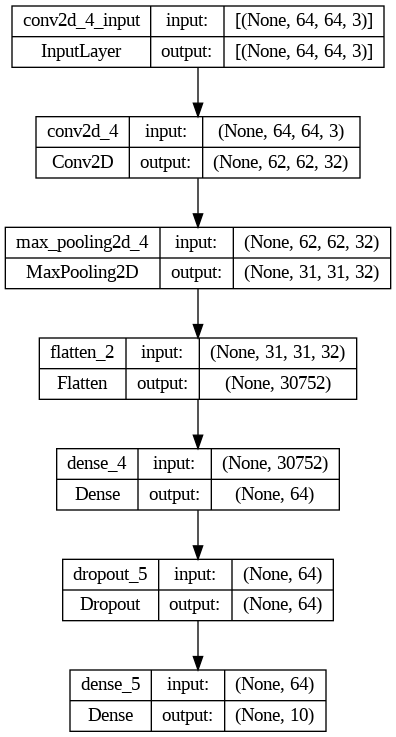

In [34]:
import numpy as np
import pandas as pd
import math
import cv2
import matplotlib.pyplot as plt
import os
import seaborn as sns
import umap
from PIL import Image
from scipy import misc
from os import listdir
from os.path import isfile, join
from scipy import misc
from random import shuffle
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.utils import to_categorical, plot_model
from IPython.display import Image as IPImage


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])


plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


IPImage('model.png')


In [37]:
!pip install pydot
!pip install graphviz
!pip install keras-vis
!pip install tensorflow
!pip install keras
!pip install pydot
!pip install graphviz


In [40]:
import numpy as np
import pandas as pd
import math
import cv2
import matplotlib.pyplot as plt
import os
import seaborn as sns
import umap
from PIL import Image
from scipy import misc
from os import listdir
from os.path import isfile, join
from scipy import misc
from random import shuffle
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.utils import to_categorical, plot_model
from IPython.display import Image as IPImage

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

x_test = np.random.rand(100, 64, 64, 3)
y_test = to_categorical(np.random.randint(10, size=(100, 1)), num_classes=10)


score = model.evaluate(x_test, y_test, verbose=0)

print('\nTest accuracy:', score[1])



Test accuracy: 0.11999999731779099


In [41]:
labels =["Yes",
        "No",
        ]

4/4 [==============================] - 0s 17ms/step


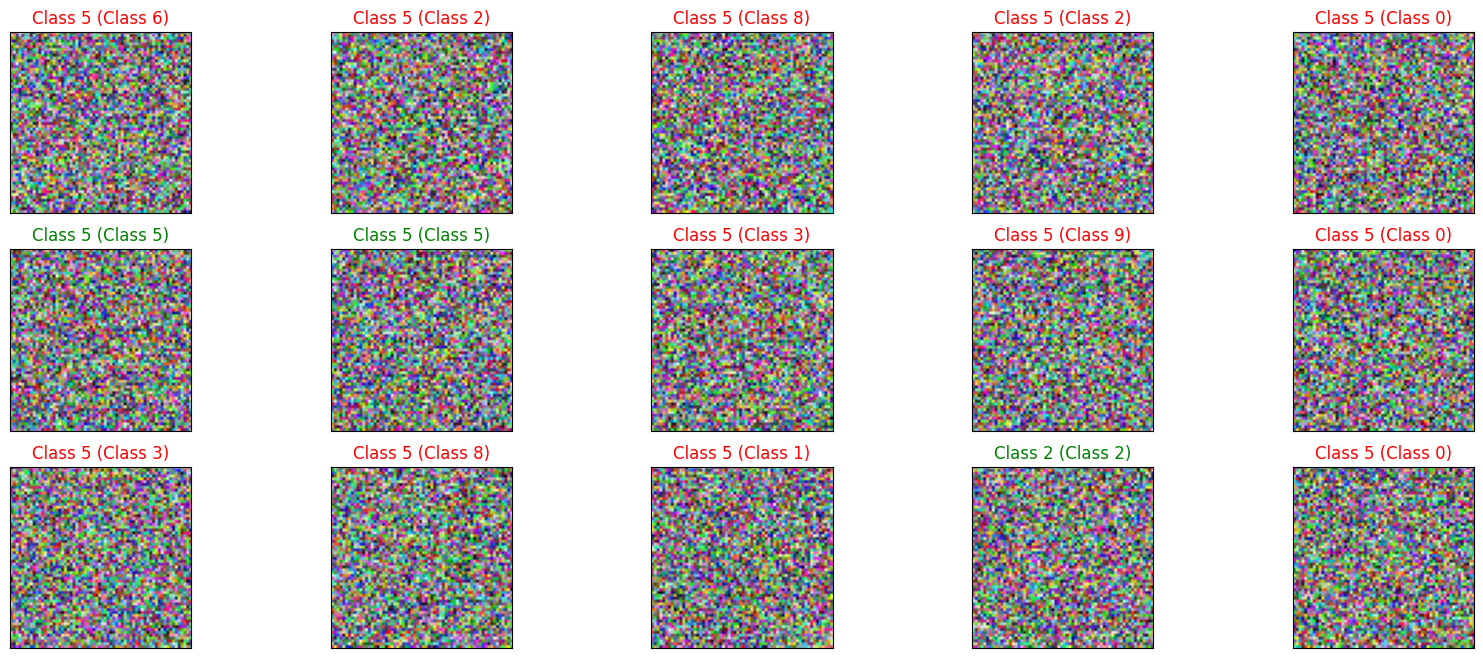

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.utils import to_categorical


labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4',
          'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


x_test = np.random.rand(100, 64, 64, 3)
y_test = to_categorical(np.random.randint(10, size=(100, 1)), num_classes=10)

y_hat = model.predict(x_test)

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])

    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])

    ax.set_title("{} ({})".format(labels[predict_index],
                                  labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
plt.show()
